<a href="https://colab.research.google.com/github/SeongcheolKim/word2vec/blob/main/dog_vs_cat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sckim04","key":"2db6de1fbce8398279bc3b098787beb3"}'}

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle competitions download -c dogs-vs-cats

100% 811M/812M [00:04<00:00, 257MB/s]
100% 812M/812M [00:04<00:00, 207MB/s]


In [4]:
!unzip -qq dogs-vs-cats.zip
!unzip -qq train.zip

In [5]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")
def make_subset(subset_name, start_index, end_index):
  for category in ("cat", "dog"):
    dir = new_base_dir / subset_name / category
    os.makedirs(dir)
    fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
    for fname in fnames:
      shutil.copyfile(src=original_dir / fname, dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

In [6]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 18, 18, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 9, 9, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 7, 7, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │          12,545 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 991,041 (3.78 MB)

 Trainable params: 991,041 (3.78 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

In [8]:
from tensorflow.keras.utils import image_dataset_from_directory

train_daset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32
)

validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32
)

test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [9]:
for data_batch, labels_batch in train_daset:
  print("data batch shape:", data_batch.shape)
  print("labels batch shape:", labels_batch.shape)
  break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


In [10]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='conv_from_scratch.h5',
        save_best_only=True,
        monitor='val_loss'
    )
]

history = model.fit(
    train_daset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks
)

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.5100 - loss: 0.6977

63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.5100 - loss: 0.6977 - val_accuracy: 0.5000 - val_loss: 0.6930
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5002 - loss: 0.6928

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.5005 - loss: 0.6928 - val_accuracy: 0.5000 - val_loss: 0.6886
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5728 - loss: 0.6838

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.5732 - loss: 0.6836 - val_accuracy: 0.6300 - val_loss: 0.6422
Epoch 4/30
61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6372 - loss: 0.6485

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.6368 - loss: 0.6485 - val_accuracy: 0.6620 - val_loss: 0.6282
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.6734 - loss: 0.6124 - val_accuracy: 0.6050 - val_loss: 0.6691
Epoch 6/30
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.6911 - loss: 0.5940

63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 83ms/step - accuracy: 0.6914 - loss: 0.5934 - val_accuracy: 0.6970 - val_loss: 0.5717
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 0.7123 - loss: 0.5470 - val_accuracy: 0.6890 - val_loss: 0.5923
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.7551 - loss: 0.5026 - val_accuracy: 0.7090 - val_loss: 0.5740
Epoch 9/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.7657 - loss: 0.4925 - val_accuracy: 0.6800 - val_loss: 0.6881
Epoch 10/30
61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7930 - loss: 0.4271

63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.7939 - loss: 0.4262 - val_accuracy: 0.7520 - val_loss: 0.5625
Epoch 11/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - accuracy: 0.8452 - loss: 0.3631 - val_accuracy: 0.6990 - val_loss: 0.6837
Epoch 12/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.8488 - loss: 0.3092 - val_accuracy: 0.7480 - val_loss: 0.6253
Epoch 13/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.8967 - loss: 0.2488 - val_accuracy: 0.7410 - val_loss: 0.7838
Epoch 14/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9287 - loss: 0.1879 - val_accuracy: 0.7160 - val_loss: 0.8203
Epoch 15/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9368 - loss: 0.1693 - val_accuracy: 0.7120 - val_loss: 0.8772
Epoch 16/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.9536 - loss: 0.1140 - val_accuracy: 0.7000 - val_loss: 1.3153
Epoch 17/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - accuracy: 0.9436 - loss: 0.1471 - val_accuracy: 0.7480 - val_l

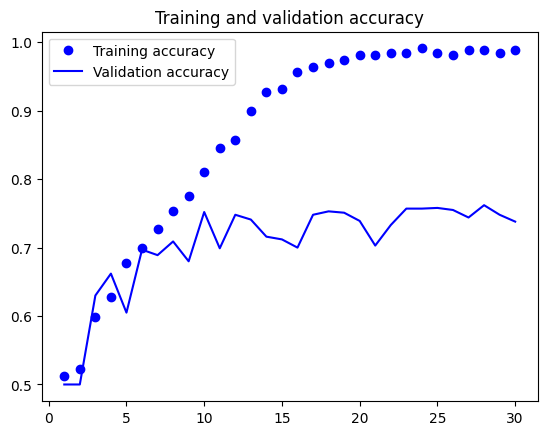

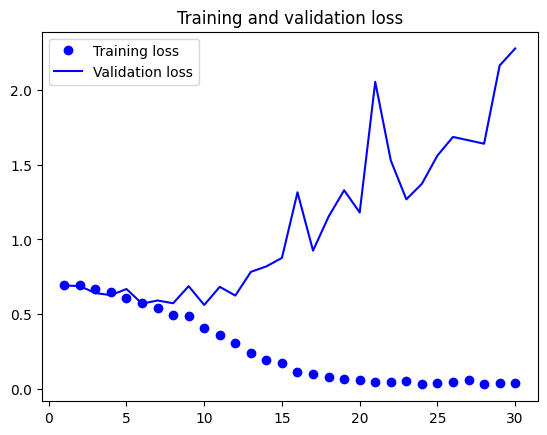

In [11]:
import matplotlib.pyplot as plt

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [12]:
test_model = keras.models.load_model("conv_from_scratch.h5")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.7243 - loss: 0.6032
Test accuracy: 0.741


In [13]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

In [14]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

In [15]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='convnet_from_scratch_with_augmentation.h5',
        save_best_only=True,
        monitor='val_loss'
    )
]
history = model.fit(
    train_daset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks
)

Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4937 - loss: 0.7251

63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - accuracy: 0.4938 - loss: 0.7248 - val_accuracy: 0.5000 - val_loss: 0.6919
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.4901 - loss: 0.6938 - val_accuracy: 0.5000 - val_loss: 0.6927
Epoch 3/100
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.4975 - loss: 0.6994

63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 0.4988 - loss: 0.6994 - val_accuracy: 0.5800 - val_loss: 0.6816
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.5652 - loss: 0.6872 - val_accuracy: 0.5380 - val_loss: 0.6898
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.5889 - loss: 0.6760 - val_accuracy: 0.5280 - val_loss: 0.6890
Epoch 6/100
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6264 - loss: 0.6567

63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 0.6264 - loss: 0.6567 - val_accuracy: 0.6050 - val_loss: 0.6584
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.6597 - loss: 0.6401 - val_accuracy: 0.5200 - val_loss: 0.8180
Epoch 8/100
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.6797 - loss: 0.6261

63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.6791 - loss: 0.6261 - val_accuracy: 0.6520 - val_loss: 0.6302
Epoch 9/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 0.6728 - loss: 0.6052 - val_accuracy: 0.6360 - val_loss: 0.6325
Epoch 10/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step - accuracy: 0.6808 - loss: 0.5976 - val_accuracy: 0.5250 - val_loss: 1.1975
Epoch 11/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6738 - loss: 0.6439

63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - accuracy: 0.6739 - loss: 0.6434 - val_accuracy: 0.6690 - val_loss: 0.5985
Epoch 12/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.7174 - loss: 0.5752 - val_accuracy: 0.6560 - val_loss: 0.6094
Epoch 13/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7193 - loss: 0.5719

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.7192 - loss: 0.5720 - val_accuracy: 0.7150 - val_loss: 0.5567
Epoch 14/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7287 - loss: 0.5530

63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 0.7286 - loss: 0.5531 - val_accuracy: 0.7070 - val_loss: 0.5513
Epoch 15/100
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.7306 - loss: 0.5435

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.7305 - loss: 0.5436 - val_accuracy: 0.7110 - val_loss: 0.5468
Epoch 16/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.7578 - loss: 0.5218 - val_accuracy: 0.7050 - val_loss: 0.5816
Epoch 17/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.7422 - loss: 0.5428 - val_accuracy: 0.7130 - val_loss: 0.5846
Epoch 18/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.7380 - loss: 0.5399 - val_accuracy: 0.7100 - val_loss: 0.6112
Epoch 19/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.7472 - loss: 0.5072 - val_accuracy: 0.6970 - val_loss: 0.5716
Epoch 20/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7650 - loss: 0.4806

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.7649 - loss: 0.4809 - val_accuracy: 0.7190 - val_loss: 0.5443
Epoch 21/100
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7676 - loss: 0.4923

63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.7674 - loss: 0.4926 - val_accuracy: 0.7710 - val_loss: 0.4805
Epoch 22/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.7826 - loss: 0.4686 - val_accuracy: 0.7560 - val_loss: 0.4857
Epoch 23/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.7857 - loss: 0.4524 - val_accuracy: 0.7580 - val_loss: 0.4919
Epoch 24/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7660 - loss: 0.4576

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.7660 - loss: 0.4577 - val_accuracy: 0.7810 - val_loss: 0.4700
Epoch 25/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.8132 - loss: 0.4259 - val_accuracy: 0.6840 - val_loss: 0.7256
Epoch 26/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.7822 - loss: 0.4414 - val_accuracy: 0.7530 - val_loss: 0.4949
Epoch 27/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.7987 - loss: 0.4206 - val_accuracy: 0.7670 - val_loss: 0.5004
Epoch 28/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.8198 - loss: 0.4067 - val_accuracy: 0.7720 - val_loss: 0.4802
Epoch 29/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.8136 - loss: 0.4107 - val_accuracy: 0.7460 - val_loss: 0.6720
Epoch 30/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8203 - loss: 0.4056

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.8202 - loss: 0.4058 - val_accuracy: 0.8010 - val_loss: 0.4338
Epoch 31/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 0.8154 - loss: 0.3871 - val_accuracy: 0.6410 - val_loss: 1.1394
Epoch 32/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 0.8080 - loss: 0.4483 - val_accuracy: 0.7840 - val_loss: 0.4973
Epoch 33/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - accuracy: 0.8375 - loss: 0.3827 - val_accuracy: 0.7810 - val_loss: 0.6327
Epoch 34/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 55ms/step - accuracy: 0.8417 - loss: 0.3612 - val_accuracy: 0.7720 - val_loss: 0.5004
Epoch 35/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.8196 - loss: 0.3831 - val_accuracy: 0.7420 - val_loss: 0.6564
Epoch 36/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.8229 - loss: 0.3950 - val_accuracy: 0.7930 - val_loss: 0.5174
Epoch 37/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 0.8583 - loss: 0.3199 - val_accuracy: 0.7520 

63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.8676 - loss: 0.3145 - val_accuracy: 0.8020 - val_loss: 0.4324
Epoch 42/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.8642 - loss: 0.3233 - val_accuracy: 0.7830 - val_loss: 0.5273
Epoch 43/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.8697 - loss: 0.2989 - val_accuracy: 0.8000 - val_loss: 0.4553
Epoch 44/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.8632 - loss: 0.3260 - val_accuracy: 0.8100 - val_loss: 0.4742
Epoch 45/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.8733 - loss: 0.3041 - val_accuracy: 0.7980 - val_loss: 0.4569
Epoch 46/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.8779 - loss: 0.2873 - val_accuracy: 0.7990 - val_loss: 0.5897
Epoch 47/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 0.8718 - loss: 0.3159 - val_accuracy: 0.7720 - val_loss: 0.7947
Epoch 48/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.8712 - loss: 0.3208 - val_accuracy: 0.8180 

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.8800 - loss: 0.2814 - val_accuracy: 0.8380 - val_loss: 0.4313
Epoch 52/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.9022 - loss: 0.2487 - val_accuracy: 0.8000 - val_loss: 0.6239
Epoch 53/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.8822 - loss: 0.2701 - val_accuracy: 0.8370 - val_loss: 0.4565
Epoch 54/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.8894 - loss: 0.2865 - val_accuracy: 0.8110 - val_loss: 0.5979
Epoch 55/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.8837 - loss: 0.2606 - val_accuracy: 0.8290 - val_loss: 0.4884
Epoch 56/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.9090 - loss: 0.2344 - val_accuracy: 0.8120 - val_loss: 0.5941
Epoch 57/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8913 - loss: 0.2709

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.8914 - loss: 0.2705 - val_accuracy: 0.8410 - val_loss: 0.4281
Epoch 58/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.9172 - loss: 0.2270 - val_accuracy: 0.8140 - val_loss: 0.5834
Epoch 59/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.9145 - loss: 0.2131 - val_accuracy: 0.7760 - val_loss: 0.8797
Epoch 60/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.8954 - loss: 0.2882 - val_accuracy: 0.8290 - val_loss: 0.4838
Epoch 61/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.9207 - loss: 0.2010 - val_accuracy: 0.8250 - val_loss: 0.5277
Epoch 62/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.9199 - loss: 0.2138 - val_accuracy: 0.8090 - val_loss: 0.5990
Epoch 63/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 0.9187 - loss: 0.2172 - val_accuracy: 0.7760 - val_loss: 0.6790
Epoch 64/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.9147 - loss: 0.2110 - val_accuracy: 0.8060 

In [16]:
test_model = keras.models.load_model("convnet_from_scratch_with_augmentation.h5")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.8247 - loss: 0.5497
Test accuracy: 0.827
